In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
from PIL import Image
import tqdm

from rsl_depth_completion.diffusion.inference_utils import sample
from rsl_depth_completion.diffusion.configs import DiffusionConfig
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision as tv
from rsl_depth_completion.diffusion.training_utils import q_sample
from rsl_depth_completion.diffusion.utils import extract
from rsl_depth_completion.diffusion.utils import set_seed
from torchvision.utils import save_image
from rsl_depth_completion.diffusion.schedulers import (cosine_beta_schedule,
linear_beta_schedule,
quadratic_beta_schedule,
sigmoid_beta_schedule)
import torch.nn.functional as F
from torch.optim import Adam
import gc

from pathlib import Path
import shutil
import numpy as np
import requests
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from minimagen.training import _Rescale, _fetch_single_image

%matplotlib inline
%autoreload 2

/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2023-04-19 14:14:35.024007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 14:14:35.122250: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on

# config

In [2]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./imagen_results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(parents=True,exist_ok = True)

init_image_size = (352, 1216)
crop_image_size = (352, 1216 // 3)
target_image_size = (152, 200)
input_channels = 1
batch_size = 2



# model

In [3]:
from rsl_depth_completion.conditional_diffusion.utils import get_model_params
from rsl_depth_completion.conditional_diffusion.train import MinimagenTrain
from kbnet import data_utils
import yaml



In [4]:
import os
from datetime import datetime

import torch.utils.data
from torch import optim
from minimagen.training import (
    ConceptualCaptions,
    get_minimagen_dl_opts,
    create_directory,
)



In [5]:
import argparse
import torch
args = argparse.Namespace(**{
    "PARAMETERS": "./imagen_parameters",
    "BATCH_SIZE": 2,
    "NUM_WORKERS": 0,
    "EPOCHS": 5,
    "OPTIM_LR": 0.001,
    "ACCUM_ITER": 1,
    "CHCKPT_NUM": 500,
})
params = get_model_params(args.PARAMETERS)
input_channels = 1
for k, v in params.items():
    v['channels'] = input_channels
data_args = argparse.Namespace(
    **{
        "MAX_NUM_WORDS": 64,
        "T5_NAME": params['imagen_parameters']['text_encoder_name'],
        "IMG_SIDE_LEN": params['imagen_parameters']["image_sizes"][1],
        "TRAIN_VALID_FRAC": 0.9,
    }
)


In [6]:

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = 'overfit_img_img_kitti'
dir_path = f"./training_{exp_name}"
training_dir = create_directory(dir_path)

In [7]:
from datasets import load_dataset
from minimagen.training import MinimagenDataset

dset = load_dataset("conceptual_captions")

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/home/master/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
train_val_num = args.BATCH_SIZE*3
val_num = args.BATCH_SIZE+1
vi = dset["validation"]["image_url"][:val_num]
vc = dset["validation"]["caption"][:val_num]
ti = dset["train"]["image_url"][:train_val_num]
tc = dset["train"]["caption"][:train_val_num]
new_dset = {
    "train": {
        "image_url": ti,
        "caption": tc,
    },
    "num_rows": train_val_num,
    "validation": {
        "image_url": vi,
        "caption": vc,
    },
    "num_rows": val_num,
}
print(len(new_dset["train"]["image_url"]))

6


In [9]:

extractor_model_ref = "openai/clip-vit-base-patch32"
extractor_model = CLIPModel.from_pretrained(extractor_model_ref)
extractor_processor = CLIPProcessor.from_pretrained(extractor_model_ref)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
ds_config = argparse.Namespace(**yaml.safe_load(open("/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/configs/data/kitti_custom.yaml"))['ds_config'])
ds_config.use_pose = "photo" in ds_config.train_mode
ds_config.result = ds_config.result_dir
ds_config.use_rgb = ("rgb" in ds_config.input) or ds_config.use_pose
ds_config.use_d = "d" in ds_config.input
ds_config.use_g = "g" in ds_config.input
val_image_paths = data_utils.read_paths(ds_config.val_image_path)
val_sparse_depth_paths = data_utils.read_paths(
    ds_config.val_sparse_depth_path
)
val_intrinsics_paths = data_utils.read_paths(
    ds_config.val_intrinsics_path
)
val_ground_truth_paths = data_utils.read_paths(
    ds_config.val_ground_truth_path
)

In [26]:
from rsl_depth_completion.data.kitti.kitti_dataset import CustomKittiDCDataset

class MinimagenDatasetCustom(CustomKittiDCDataset):
    def __init__(
        self,
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)

    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        img = items['d']
        cond_image = items['img']

        pixel_values = extractor_processor(
            images=torch.stack(
                [
                    torch.from_numpy(np.array(cond_image)),
                    torch.from_numpy(np.array(cond_image)),
                ]
            ),
            return_tensors="pt",
        ).pixel_values
        embedding = extractor_model.get_image_features(pixel_values=pixel_values)
        embedding = embedding.unsqueeze(1).to(device)
        encoding = embedding
        mask = torch.ones(embedding.shape[0], 1).bool().to(device)

        return {"image": img.detach(), "encoding": encoding.detach(), "mask": mask.detach()}

In [27]:
ds = MinimagenDatasetCustom(
    ds_config=ds_config,
                image_paths=val_image_paths,
                sparse_depth_paths=val_sparse_depth_paths,
                intrinsics_paths=val_intrinsics_paths,
                ground_truth_paths=val_ground_truth_paths,
            )
x=ds[0]
x['image'].shape, x['encoding'].shape, x['mask'].shape

(torch.Size([1, 352, 1216]), torch.Size([2, 1, 512]), torch.Size([2, 1]))

In [28]:
ds_subset = torch.utils.data.Subset(ds, range(0, 6))

# Split into train/valid
train_dataset, valid_dataset = torch.utils.data.random_split(
    ds_subset, [2,4]
    # dataset_train_valid, [train_num, val_num]
)

dl_opts = {
    **get_minimagen_dl_opts(device),
    "batch_size": args.BATCH_SIZE,
    "num_workers": args.NUM_WORKERS,
}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dl_opts)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, **dl_opts)


In [29]:
len(train_dataloader), len(valid_dataloader)

(1, 2)

In [30]:
x_train=next(iter(train_dataloader))
x_val=next(iter(valid_dataloader))

In [32]:
import json

with open("full_params.json", "w") as f:
    f.write(json.dumps(params))

In [39]:
import gc; gc.collect()
torch.cuda.empty_cache()

# from minimagen.Imagen import Imagen
# from minimagen.Unet import Unet
from rsl_depth_completion.conditional_diffusion.Imagen import Imagen
from rsl_depth_completion.conditional_diffusion.Unet import Unet

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create Unets accoridng to unets_params
unets = [Unet(**params['unet_base']).to(device), Unet(**params['unet_super_resolution']).to(device)]

# Create Imagen from UNets with specified imagen parameters
imagen = Imagen(unets=unets, **params['imagen_parameters']).to(device)
args.OPTIM_LR = 0.005
optimizer = optim.Adam(imagen.parameters(), lr=args.OPTIM_LR)

In [40]:
args.EPOCHS=40
train_unet_losses, val_unet_losses=MinimagenTrain(
    exp_name,
    args,
    unets,
    imagen,
    train_dataloader,
    valid_dataloader,
    training_dir,
    optimizer,
)


### Epoch 1 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


(Base,SuperR) Unets Train Loss: (1.01647, 1.06142)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


(Base,SuperR) Unets Val Loss: (0.66023, 1.17554)
### Epoch 2 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


(Base,SuperR) Unets Train Loss: (0.693, 1.15632)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


(Base,SuperR) Unets Val Loss: (0.51705, 1.0153)
### Epoch 3 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


(Base,SuperR) Unets Train Loss: (0.50119, 1.00644)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


(Base,SuperR) Unets Val Loss: (0.55107, 0.96106)
### Epoch 4 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


(Base,SuperR) Unets Train Loss: (0.37118, 0.96437)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


(Base,SuperR) Unets Val Loss: (0.39539, 0.93784)
### Epoch 5 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


(Base,SuperR) Unets Train Loss: (0.42515, 0.94473)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


(Base,SuperR) Unets Val Loss: (0.29375, 0.9492)
### Epoch 6 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


(Base,SuperR) Unets Train Loss: (0.30933, 0.9892)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


(Base,SuperR) Unets Val Loss: (0.23274, 0.99556)
### Epoch 7 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


(Base,SuperR) Unets Train Loss: (0.89589, 1.00757)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


(Base,SuperR) Unets Val Loss: (0.44511, 0.91257)
### Epoch 8 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


(Base,SuperR) Unets Train Loss: (0.21432, 0.95052)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


(Base,SuperR) Unets Val Loss: (0.20305, 0.9098)
### Epoch 9 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


(Base,SuperR) Unets Train Loss: (0.29548, 0.95329)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


(Base,SuperR) Unets Val Loss: (0.17963, 0.93564)
### Epoch 10 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


(Base,SuperR) Unets Train Loss: (0.59317, 0.86511)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


(Base,SuperR) Unets Val Loss: (0.17664, 0.91122)
### Epoch 11 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


(Base,SuperR) Unets Train Loss: (0.2411, 0.85762)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


(Base,SuperR) Unets Val Loss: (0.16354, 0.85938)
### Epoch 12 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


(Base,SuperR) Unets Train Loss: (0.4001, 0.91721)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


(Base,SuperR) Unets Val Loss: (0.29434, 0.87504)
### Epoch 13 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(Base,SuperR) Unets Train Loss: (0.15664, 0.83645)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


(Base,SuperR) Unets Val Loss: (0.30195, 0.80671)
### Epoch 14 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


(Base,SuperR) Unets Train Loss: (0.13958, 0.86836)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


(Base,SuperR) Unets Val Loss: (0.18551, 0.80152)
### Epoch 15 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


(Base,SuperR) Unets Train Loss: (0.16001, 0.79514)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


(Base,SuperR) Unets Val Loss: (0.12575, 0.82399)
### Epoch 16 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


(Base,SuperR) Unets Train Loss: (0.11154, 0.78187)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


(Base,SuperR) Unets Val Loss: (0.49851, 0.838)
### Epoch 17 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


(Base,SuperR) Unets Train Loss: (0.10054, 0.74662)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


(Base,SuperR) Unets Val Loss: (0.1738, 0.85151)
### Epoch 18 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(Base,SuperR) Unets Train Loss: (0.28738, 0.77016)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


(Base,SuperR) Unets Val Loss: (0.44283, 0.71638)
### Epoch 19 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


(Base,SuperR) Unets Train Loss: (0.19565, 0.7851)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


(Base,SuperR) Unets Val Loss: (0.11614, 0.69229)
### Epoch 20 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


(Base,SuperR) Unets Train Loss: (0.49639, 0.70777)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


(Base,SuperR) Unets Val Loss: (0.17641, 0.74863)
### Epoch 21 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


(Base,SuperR) Unets Train Loss: (0.08765, 0.6627)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


(Base,SuperR) Unets Val Loss: (0.16138, 0.69058)
### Epoch 22 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


(Base,SuperR) Unets Train Loss: (0.08309, 0.66886)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


(Base,SuperR) Unets Val Loss: (0.12118, 0.63272)
### Epoch 23 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


(Base,SuperR) Unets Train Loss: (0.08685, 0.67838)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


(Base,SuperR) Unets Val Loss: (0.11994, 0.64796)
### Epoch 24 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


(Base,SuperR) Unets Train Loss: (0.26942, 0.66788)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


(Base,SuperR) Unets Val Loss: (0.15359, 0.61307)
### Epoch 25 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


(Base,SuperR) Unets Train Loss: (0.08746, 0.70066)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


(Base,SuperR) Unets Val Loss: (0.27182, 0.64397)
### Epoch 26 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


(Base,SuperR) Unets Train Loss: (0.18347, 0.58699)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


(Base,SuperR) Unets Val Loss: (0.14829, 0.59693)
### Epoch 27 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


(Base,SuperR) Unets Train Loss: (0.49628, 0.72377)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


(Base,SuperR) Unets Val Loss: (0.09825, 0.68189)
### Epoch 28 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(Base,SuperR) Unets Train Loss: (0.09467, 0.74869)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


(Base,SuperR) Unets Val Loss: (0.20273, 0.5516)
### Epoch 29 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(Base,SuperR) Unets Train Loss: (0.41078, 0.5756)


valid: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


(Base,SuperR) Unets Val Loss: (0.08847, 0.64581)
### Epoch 30 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


(Base,SuperR) Unets Train Loss: (0.23172, 0.55391)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


(Base,SuperR) Unets Val Loss: (0.1731, 0.69131)
### Epoch 31 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


(Base,SuperR) Unets Train Loss: (0.11334, 0.5376)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


(Base,SuperR) Unets Val Loss: (0.19077, 0.67729)
### Epoch 32 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


(Base,SuperR) Unets Train Loss: (0.11931, 0.49026)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


(Base,SuperR) Unets Val Loss: (0.22753, 0.55273)
### Epoch 33 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


(Base,SuperR) Unets Train Loss: (0.46263, 0.50838)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


(Base,SuperR) Unets Val Loss: (0.0785, 0.49264)
### Epoch 34 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


(Base,SuperR) Unets Train Loss: (0.19734, 0.47292)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


(Base,SuperR) Unets Val Loss: (0.08798, 0.52997)
### Epoch 35 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


(Base,SuperR) Unets Train Loss: (0.17511, 0.46353)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


(Base,SuperR) Unets Val Loss: (0.11926, 0.60983)
### Epoch 36 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


(Base,SuperR) Unets Train Loss: (0.11404, 0.43703)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


(Base,SuperR) Unets Val Loss: (0.10286, 0.50771)
### Epoch 37 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


(Base,SuperR) Unets Train Loss: (0.06157, 0.70559)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


(Base,SuperR) Unets Val Loss: (0.16251, 0.66222)
### Epoch 38 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


(Base,SuperR) Unets Train Loss: (0.0647, 0.40441)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


(Base,SuperR) Unets Val Loss: (0.14759, 0.39536)
### Epoch 39 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


(Base,SuperR) Unets Train Loss: (0.06315, 0.42514)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


(Base,SuperR) Unets Val Loss: (0.07702, 0.47859)
### Epoch 40 of 40 ###


train: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


(Base,SuperR) Unets Train Loss: (0.42677, 0.3999)


valid: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

(Base,SuperR) Unets Val Loss: (0.19586, 0.38244)


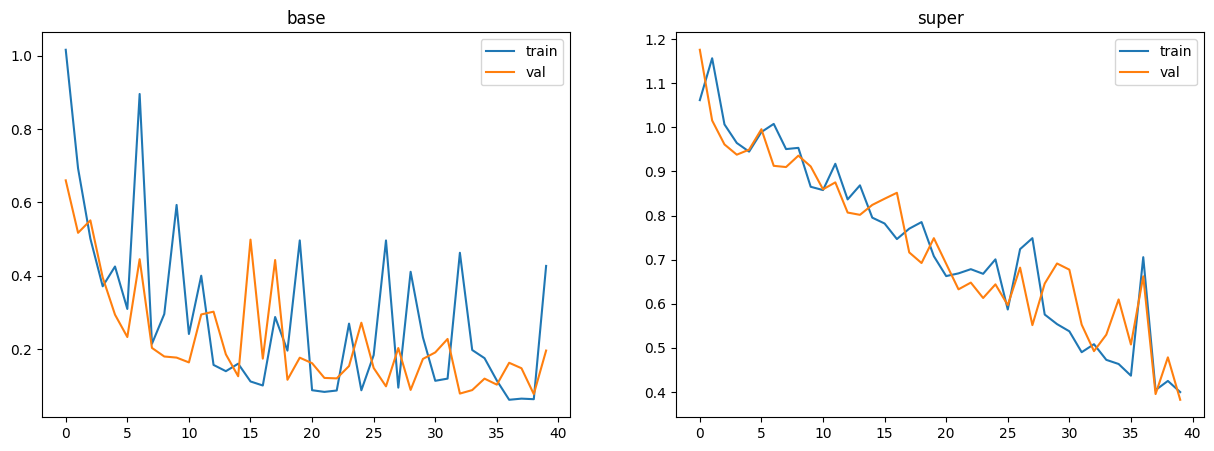

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, unet_name in enumerate(['base', 'super']):
    ax[i].set_title(unet_name)
    ax[i].plot(train_unet_losses[unet_name], label='train')
    ax[i].plot(val_unet_losses[unet_name], label='val')
    ax[i].legend()